In [1]:
from disaster import config
import numpy as np
import pandas as pd

from sklearn import metrics

import json
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn

# To check all 'rcParams' options:
# rcParams.keys()

params = {
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.figsize': [6, 4],
    'figure.titlesize': 'large'
   }

rcParams.update(params)

In [3]:
meta = {}
predict = {}
actual = {}
df = {}
    
experiments = {
    '20200330174603': '[regex,vaderSentiment]',
    '20200330195510': '[regex,vaderSentiment,glove]',
    '20200330181603': '[regex,vaderSentiment,bert]'
}
    
for timestr, feat in experiments.items():
    
    for s in ['train', 'valid']:

        # Load metadata
        
        path = (
            '{0}/{1}_metadata_{2}.json'
            .format(config.models_path, timestr, s)
            )

        with open(path) as f:
            meta[feat, s] = json.load(f)

        # Load predictions

        path = (
            '{0}/{1}_{2}_predict.csv'
            .format(config.predict_path, timestr, s)
            )

        predict[feat,s] = pd.read_csv(path)

        predict[feat, s].set_index('id', inplace=True)
        
        # Load actuals

        path = (
            '{0}/{1}.csv'
            .format(config.data_path, s)
            )

        actual[feat, s] = pd.read_csv(path)

        actual[feat, s].set_index('id', inplace=True)
    
        # Join tables

        df[feat, s] = actual[feat, s].join(predict[feat, s])
        df[feat, s].rename(columns={'target': 'actual', 'class': 'pred'}, inplace=True)
        df[feat, s].drop(columns=['keyword', 'location'], inplace=True)

In [4]:
for timestr, feat in experiments.items():
    
    print('===============')
    print(feat)
    print('')
    print('-- TRAIN --')
    print('')
    pp.pprint(meta[feat, 'train'])
    print('')
    print('')
    print('-- VALID --')
    print('')
    pp.pprint(meta[feat, 'valid'])
    print('')
    print('')

[regex,vaderSentiment]

-- TRAIN --

{   'AUC': 0.7248888583781776,
    'KS': 0.34264736355673536,
    'alpha': 1.0,
    'best_params_': {   'max_depth': 12,
                        'min_samples_split': 300,
                        'n_estimators': 600},
    'class_weight': 'balanced',
    'classification_report': {   '0': {   'f1-score': 0.6988811415599155,
                                          'precision': 0.7251009421265141,
                                          'recall': 0.6744913928012519,
                                          'support': 3195},
                                 '1': {   'f1-score': 0.6392073052263455,
                                          'precision': 0.6126629422718808,
                                          'recall': 0.6681559707554834,
                                          'support': 2462},
                                 'accuracy': 0.6717341347003712,
                                 'macro avg': {   'f1-score': 0.6690442233931305,
     

In [5]:
# TPR: True Positive Rate
# FPR: False Positive Rate
# THR: THRESHOLD
# KS: Kolmogorov–Smirnov

fpr = {}
tpr = {}
thr = {}
ks = {}
ks_idx = {}
ks_thr = {}

for timestr, feat in experiments.items():
    for s in ['train', 'valid']:

        fpr[feat, s], tpr[feat, s], thr[feat, s] = (
            metrics.roc_curve(
            y_true=df[feat, s]['actual'].values,
            y_score=df[feat, s]['prob_1'].values,
            pos_label=1,
            drop_intermediate=False
            )
        )
        
        diff = np.abs(tpr[feat, s] - fpr[feat, s])
        
        # Kolmogorov–Smirnov
        ks[feat, s] = np.max(diff)
        
        # Numpy index of the maximum separation between TPR and FPR
        ks_idx[feat, s] = np.argmax(diff)
        
        # Optimum threshold based on KS criterium
        ks_thr[feat, s] = thr[feat, s][ks_idx[feat, s]]
        
pp.pprint(ks_thr)

{   ('[regex,vaderSentiment,bert]', 'train'): 0.4773356577497496,
    ('[regex,vaderSentiment,bert]', 'valid'): 0.4915625763583465,
    ('[regex,vaderSentiment,glove]', 'train'): 0.4645602039097906,
    ('[regex,vaderSentiment,glove]', 'valid'): 0.5567982073278616,
    ('[regex,vaderSentiment]', 'train'): 0.4836513771301797,
    ('[regex,vaderSentiment]', 'valid'): 0.4459738859562099}


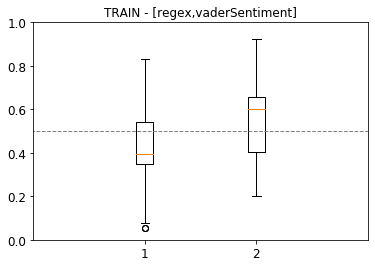

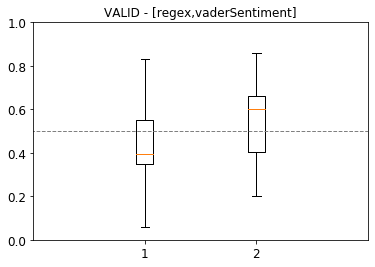

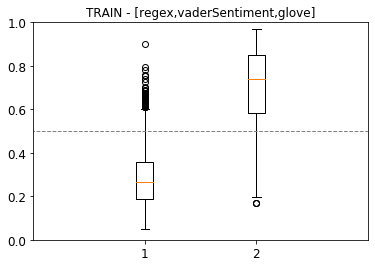

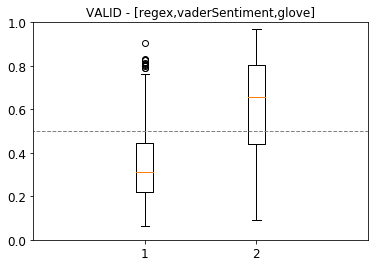

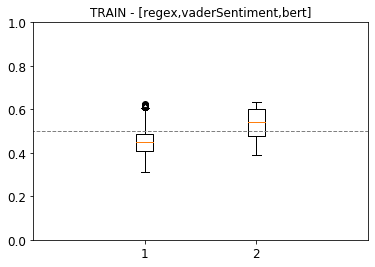

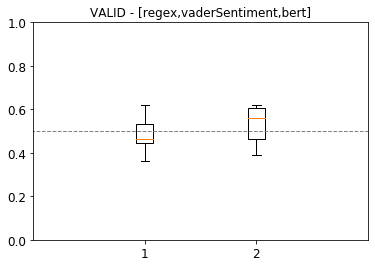

In [6]:
for timestr, feat in experiments.items():
    for s in ['train', 'valid']:
        
        fig, ax = plt.subplots()

        mask_0 = (df[feat, s]['actual'].values == 0)
        mask_1 = (df[feat, s]['actual'].values == 1)

        proba_0 = pd.Series(df[feat, s]['prob_1'])[mask_0].values
        proba_1 = pd.Series(df[feat, s]['prob_1'])[mask_1].values

        plt.ylim([0, 1])
        plt.xlim([0, 3])
        
        plt.title('{0} - {1}'.format(s.upper(), feat))
        
        ax.boxplot([proba_0, proba_1])
        
        plt.plot(
            [-5., 5.],
            [0.5, 0.5],
            color='gray',
            lw=1,
            linestyle='--'
        )
        
        filename = 'out/boxplots_{0}_{1}'.format(timestr, s)
        
        fig.savefig(filename, dpi=300)
        
        plt.show()

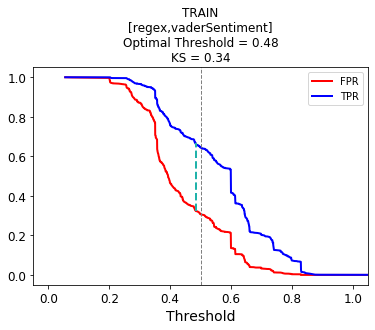

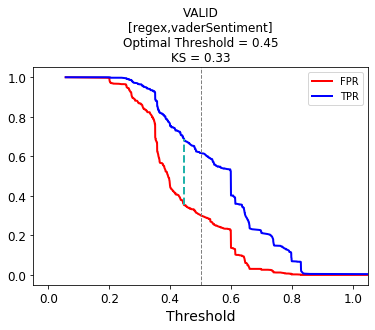

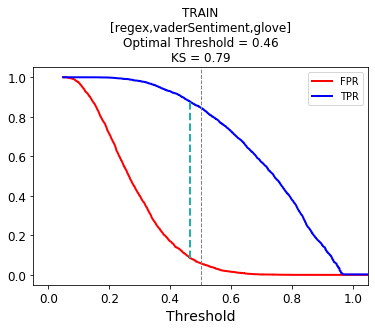

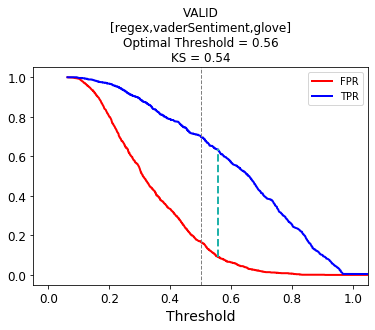

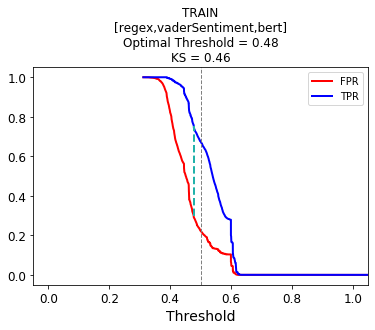

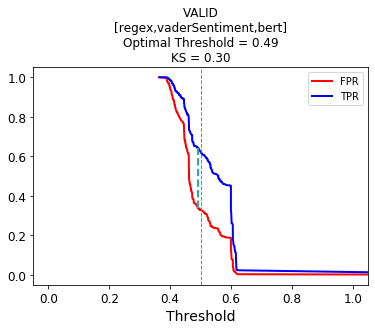

In [7]:
for timestr, feat in experiments.items():
    for s in ['train', 'valid']:
        
        fig, ax = plt.subplots()
        
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        
        plt.title('{0} - {1}'.format(s.upper(), feat))
        
        plt.plot(thr[feat, s], fpr[feat, s], color='red', lw=2, linestyle='-', label='FPR')
        plt.plot(thr[feat, s], tpr[feat, s], color='blue', lw=2, linestyle='-', label='TPR')
        
        plt.plot([0.5, 0.5], [-0.05, 1.05], color='gray', lw=1, linestyle='--')
        
        idx = ks_idx[feat, s]
        
        plt.plot(
            [ks_thr[feat, s], ks_thr[feat, s]],
            [fpr[feat, s][idx], tpr[feat, s][idx]],
            color='lightseagreen',
            lw=2,
            linestyle='--'
        )
                
        legend = ax.legend(loc='upper right')
        
        plt.xlabel('Threshold')
        
        plt.title(
            '{0}\n{1}\nOptimal Threshold = {2:.2f}\nKS = {3:.2f}'
            .format(s.upper(), feat, ks_thr[feat, s], ks[feat, s])
        )
        
        filename = 'out/xpr_vs_thr_{0}_{1}'.format(timestr, s)
        
        fig.savefig(filename, dpi=300)
        
        plt.show()

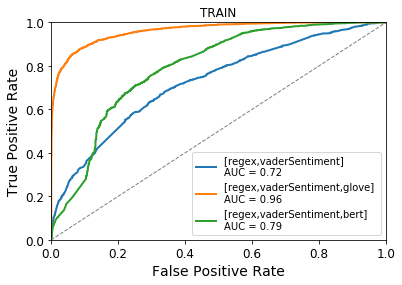

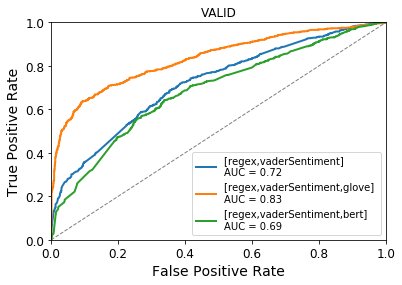

In [8]:
for s in ['train', 'valid']:

    fig, ax = plt.subplots()

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    for timestr, feat in experiments.items():

            roc_auc = metrics.auc(fpr[feat, s], tpr[feat, s])

            label = '{0} \nAUC = {1:.2f}'.format(feat, roc_auc)

            plt.plot(fpr[feat, s], tpr[feat, s], lw=2, linestyle='-', label=label)

    legend = ax.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(s.upper())
    filename = 'out/roc_{0}_{1}'.format(timestr, s)
    fig.savefig(filename, dpi=300)
    plt.show()

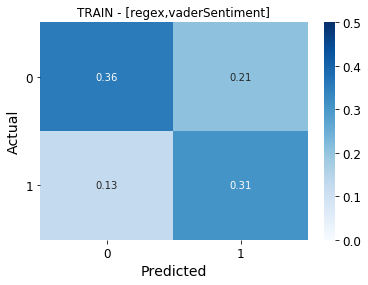

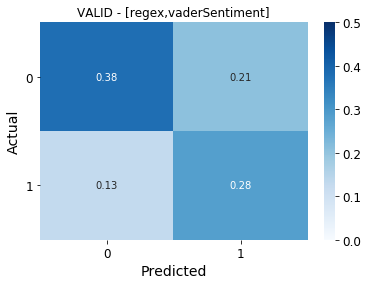

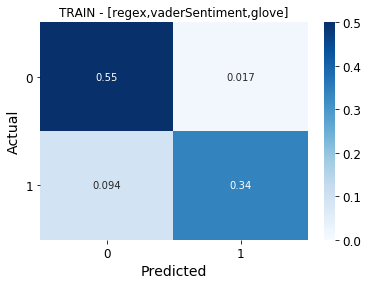

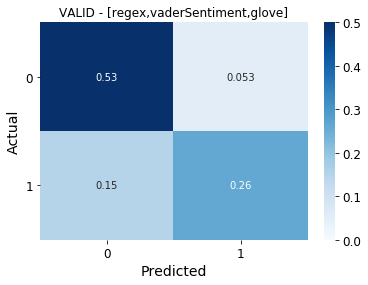

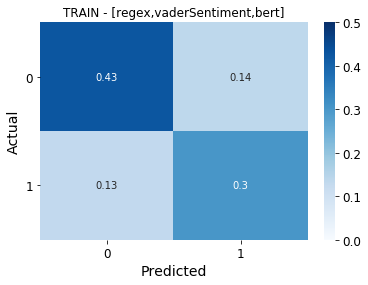

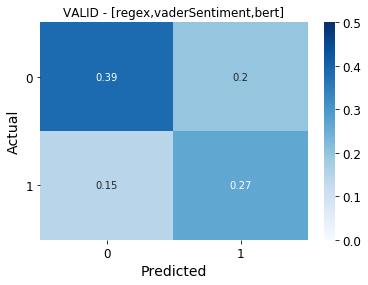

In [9]:
for timestr, feat in experiments.items():
    for s in ['train', 'valid']:

        confusion_matrix = pd.crosstab(
            df[feat, s]['actual'],
            df[feat, s]['pred'],
            rownames=['Actual'],
            colnames=['Predicted']
        )
        
        cm_sum = sum(sum(confusion_matrix.values))
        
        confusion_matrix = confusion_matrix / cm_sum

        svm = sn.heatmap(
            confusion_matrix,
            annot=True,
            cmap='Blues',
            vmin=0,
            vmax=0.5
        )
        
        plt.title('{0} - {1}'.format(s.upper(), feat))
        
        plt.yticks(rotation=0)
        
        filename = 'out/confusion_norm_{0}_{1}'.format(timestr, s)
        
        figure = svm.get_figure()  
        figure.savefig(filename, dpi=300)

        plt.show()

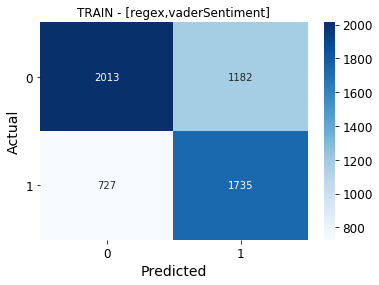

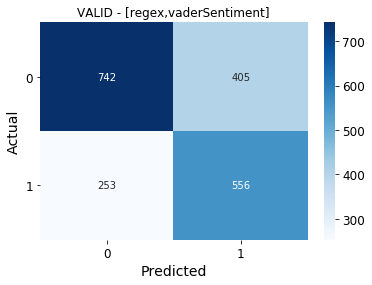

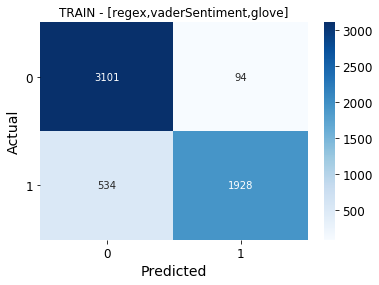

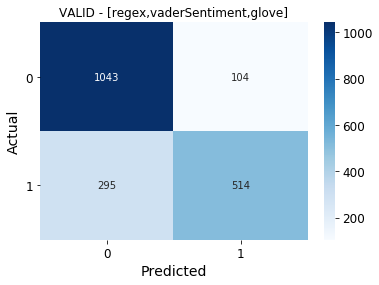

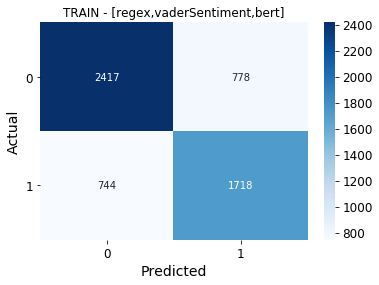

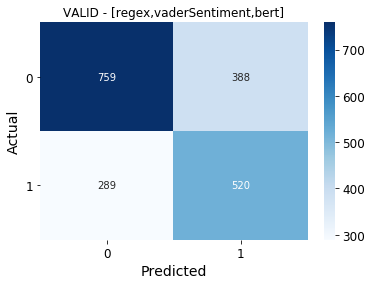

In [10]:
for timestr, feat in experiments.items():
    for s in ['train', 'valid']:

        confusion_matrix = pd.crosstab(
            df[feat, s]['actual'],
            df[feat, s]['pred'],
            rownames=['Actual'],
            colnames=['Predicted']
        )

        svm = sn.heatmap(
            confusion_matrix,
            annot=True,
            cmap='Blues',
            fmt='d'
        )
        
        plt.title('{0} - {1}'.format(s.upper(), feat))
        
        plt.yticks(rotation=0)
        
        filename = 'out/confusion_raw_{0}_{1}'.format(timestr, s)
        
        figure = svm.get_figure()  
        figure.savefig(filename, dpi=300)

        plt.show()